# **Chap 4：近邻方法和均值聚类**

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, KDTree
from sklearn.cluster import KMeans
from sklearn.datasets import make_regression, make_moons, make_blobs
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
import time
from IPython import display

/home/admin/software/miniconda3/envs/dev/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


本章，我们价绍两种基于**近邻**和**距离度量**思想的最经典的机器学习方法，**K近邻方法**（又称为**K-NN**）和**K均值方法**（又称为**K-Means**）
* **KNN**能够用于解决**有监督**的**分类**和**回归**问题
* **K-Means**用于解决**无监督**的聚类问题

## **1 KNN：K近邻方法**

**K-NN** 方法是一种基本的分类与回归方法，它以实例的特征向量 $X_0\in \mathbb{R}^p$ 为输入，然后寻找他在经验数据集 $T$ 中**最近**的 $k$ 个**邻居**，然后使用**一定规则**进行预测，例如：
* 对于分类问题，利用**多数表决**的方案完成分类
* 对于回归问题，利用**平均值**完成预测

因此，**K-NN** 模型与大多数机器学习模型不同，除了超参数邻居个数 $k$ 外，它**没有模型参数**，因此**不具备显式的学习过程**，K-NN 实际上是**利用训练集对特征向量空间进行划分**，并将划分得到的“规则”作为“”模型“”

对K-NN模型而言，有三个基本的核心要素：
* 特征空间中**距离度量的方式**，用于确定邻居
* 决策规则，不同决策规则对应于所考虑的损失函数
* $k$ 值的选择

与一般得机器学习模型得介绍方法不同，我们这次将按照**算法**，**模型**和**策略**得顺序介绍**K-NN**

### **1.1 KNN算法**

K-NN算法简单，直观，给定一个训练数据集，对新的输入实例，在训练数据集中，找到与该实例最近的 $k$ 个实例，然后使用对应的决策规则完成预测

下面我们用数学语言较为严谨的表述KNN算法

假设我们拥有历史训练数据集 $T=\{(x_1,y_1),\cdots,(X_N,y_N)\}$，其中，$x_i\in\mathbb{R}^p$ 为实例的特征向量，$y_i$ 是实例的标签，如果是分类问题，则 $y_i\in\{1,2,\cdots,K\}$ （离散空间），如果是回归问题，则 $y_i\in \mathbb{R}$（连续空间）

给定测试实例 $x\in\mathbb{R}^p$，我们根据给定的**距离度量方式**，在训练集 $T$ 中找出与 $x$ 最邻近的 $k$ 个点，我们将涵盖这 $k$ 个点的 $x$ 的邻近集合记作 $N_k(x)$

* 对于分类问题，假设损失函数为**0-1损失**，因此最优决策规则为**投票表决**，实例 $x$ 的预测类别 $\hat{y}$ 为：
$$
\hat{y} = \mathop{\arg\max}\limits_{k\in\{1,2,\cdots,K\}} \sum_{x_i\in N_k(x)} \mathbb{I}(y_i=k)
$$
* 对于回归问题，假设损失函数为**平方误差**，因此最优决策规则为**均值预测**，实例 $x$ 的回归预测 $\hat{y}$ 为：
$$
\hat{y} = \frac{1}{k} \sum_{x_i\in N_k(x)} y_i
$$

KNN算法的特殊情况是 $k=1$ 时的情形，此时算法被称为**最邻近算法**，对于待预测的实例 $x$，它的所有预测结果完全取决于距离它最近的点

从上面的介绍我们能看到，**KNN没有显式的学习过程**，但仍然有一些问题需要我们解决，例如**距离度量的选择**，**找到邻居后决策规则的选择**，$k$ **值的选择**

### **1.2 KNN模型**

**KNN没有显式的模型结构**，例如回归方法中我们有 $y=f(x)=x\beta$，或者朴素贝叶斯方法中，我们用一系列先验和似然的概率对样本的后验概率建模

回顾上一节中，我们提及到的**决策边界**的概念，在这里我们希望在之后的学习过程中能对模型的决策逻辑有更整体的认知，我们**将模型建立的过程**视为模型在**特征空间**中建立了**决策流形**

事实上，对于KNN方法，当给定训练集 $T$，距离度量的方法（例如欧式距离）和 $k$ 值，模型对特征空间的划分就已经完成了，即**决策流形**的结构已经建立，接下来只需要提供决策规则就可以得到预测函数

下面的例子，我们以**分类问题**和**欧式距离**为背景进行讨论. 特征空间中，对每个训练实例点 $x_i$，距离该点比其他点更近的所有点组成一个区域，叫做**单元**（**cell**），每个训练实例点都有一个单元

所有训练实例点的单元构成**对特征空间的一个划分**，而 $k=1$ 时的最邻近算法将 $x_i$ 的标签 $y_i$ 作为其单元中所有点的类别预测结果，这样每个单元中的实例点的类别是确定的，而KNN需要考虑多个单元的结果做出综合判断

下图展示了在**欧式距离**下，一组训练数据对二维特征空间划分得到的单元

<img src="./source/Chap4/特征空间中的单元.png" style="width: 500px" align="left"/>

因此，KNN模型在**构造决策流形时依赖距离度量的方式**. 不同的距离度量方法，会得到不同的空间划分

特征空间中两个实例点的距离是**两个实例点的相似程度的一种体现**，大多数情况下，我们可以认为**距离越近，那么两个实例点越相似**，它们对用的标签结果也应该尽可能接近

KNN模型的特征空间一般是 $\mathbb{R}^p$，使用的距离是**欧氏距离**，但也可以是其他距离，如一般的 $L_p$ **距离**或者 **Minkowski距离**

设特征空间为 $\mathbb{R}^p$，$x_i,y_j\in\mathbb{R}^p$，即 $x_i=(x_i^{(1)},\cdots,x_i^{(p)})$，$x_j=(x_j^{(1)},\cdots,x_j^{(p)})$，则 $x_i,x_j$ 的 $L_p$ 距离定义为：
$$
L_p(x_i,x_j) = \left( \sum_{k=1}^{p} |x_i^{(k)} - x_j^{(k)}|^p \right)^{\frac{1}{p}}, \quad p\geq 1
$$

三种比较特殊的距离：
* $p=2$ 时，即我们熟知的**欧氏距离**
* $p=1$ 时，称为**曼哈顿距离**，它是各个维度坐标绝对值差的和
* $p=\infty$ 时，$L_{\infty}(x_i,x_j)=\max_{k} |x_i^{(k)} - x_j^{(k)}|$，即各个维度坐标绝对值差的最大值

在这里需要明确的有两点：
* 度量的选择会影响最邻近的结果（见习题）
* **默认情况下选择欧氏距离即可**，但如果有特殊的距离度量需求，则根据实际的场景和问题规划距离的计算方法

### **1.3 KNN策略**

假设给定实例 $x$ 后的 $k$ 近邻 $N_k(x)$ 已经确定，下面我们来讨论**决策规则**，我们分别就**分类问题**和**回归问题**进行讨论

**(1) 分类问题**

假设分类问题所考虑的损失函数为**0-1损失**：
$$
L(y,\hat{y}) = \mathbb{I}(y\ne \hat{y})
$$

模型得到的分类函数 $f$ 满足：
$$
f : \mathbb{R}^p \to \{1,2,\cdots,K\}
$$

则给定测试样本 $(x,y)$ 的**误分类概率**为：
$$
P\left(y\ne f(x)\right) = 1 - P\left(y = f(x)\right)
$$

设实例 $x$ 的 $k$ 个最近邻为 $N_k(x)$，**假设区域** $N_k(x)$ **的类别被判定为** $j$，则误分类率为：
$$
\frac{1}{k}\sum_{x_i\in N_k(x)} \mathbb{I}(y_i\ne j) = 1 - \frac{1}{k}\sum_{x_i \in N_k(x)} \mathbb{I}(y_i = j)
$$

要使得**误分类率最小**，即**最小化经验风险**，就要**最大化**：
$$
\sum_{s_i\in N_k(x)} \mathbb{I}(y_i = j)
$$

自然地，区域 $N_k(x)$ 的类别 $j$ 应该被标定为：
$$
j^* = \mathop{\arg\max}\limits_{k\in \{1,2,\cdots,K\}} \sum_{x_i\in N_k(x)} \mathbb{I}(y_i = k)
$$

这就是在**0-1损失函数**下，最优决策规则是**多数表决**（或者叫做**投票法**，**众数法**）的原因

**(2) 回归问题**

假设回归问题所考虑的损失函数为**平方损失**：
$$
L(y,\hat{y}) = (y - \hat{y})^2
$$

模型得到的预测函数 $f$ 满足：
$$
f : \mathbb{R}^p \to \mathbb{R}
$$

则给定测试样本 $(x,y)$ 的**误差损失**为：
$$
L = \left(y - f(x) \right)^2
$$

设实例 $x$ 的 $k$ 个最近邻为 $N_k(x)$，**假设测试实例** $(x,y)$ **和区域** $N_k(x)$ **中实例** $(x_i,y_i)$ **的分布相同**，**均为** $F$，则我们**结论上的最优预测** $f^*(x)$ 满足：
$$
f^*(x) = \mathbb{E}_F(y) = \mathop{\arg\min}\limits_{\theta\in\mathbb{R}} \mathbb{E}_F\left[(y - \theta)^2\right]
$$

这是**Chap 1**习题中证明的内容，我们在这里简单的给出最直观的证明方法，注意到：

$$
\mathbb{E}_F\left[(y-\theta)^2\right] = \mathbb{E}_F\left[(y- \mathbb{E}_F(y) + \mathbb{E}_F(y) -  \theta)^2\right] = \mathbb{E}_F\left[(y- \mathbb{E}_F(y))^2\right]  + (\mathbb{E}_F(y) -  \theta)^2 \geq \mathbb{E}_F\left[(y- \mathbb{E}_F(y))^2\right]
$$

因此，对于任何 $\theta \ne \mathbb{E}_F(y)$，**预测所带来的平方损失只会更大**

从**经验损失**考虑，我们只能用**样本**来估计期望 $\mathbb{E}_F(y)$，因此，实际的预测函数为：
$$
\hat{y} = f^*(x)  = \frac{1}{k} \sum_{x_i\in N_k(x)}y_i
$$

这就是在**平方损失**下，最优决策规则使用**平均值估计**的原因

### **1.4 考虑 $k$ 值选择**

事实上，在一般的KNN算法使用过程中，$k$ **值对模型预测性能的影响是最大的**

如果选择一个较小的 $k$ 值，就相当于用较小的邻域中的训练实例逆行预测，“学习”的**近似误差**会减小，只有与输入实例较接近（相似的）实例才会对预测结果起作用，但此时“学习”的**泛化误差**，或者**估计误差**会增大，预测结果会对近邻 $N_k(x)$ 包含的实例点**非常敏感**. 设想，如果此时邻近点恰好都是**无效的噪声点**，则预测结果完全不可靠. 总结来说，$k$ **值减小就意味着模型整体变得复杂，容易发生过拟合**

极端情况下，$k=1$ 的最近邻算法每次预测仅考虑单个样本提供的信息，如果准备期末考试只参考一套模拟卷的结果，效果往往不好

如果选择一个较大的 $k$ 值，就相当于用较大的邻域中的训练实例进行预测，有点是可以减少“学习”的**估计误差**，但缺点是“学习”的**近似误差**会增大，因为参考了太多的样本. 此时与输入实例距离较远的点（不相似的）也都会对预测起作用，导致预测结果的不可靠. 总结来说，$k$ **值增大就意味着模型整体变得简单，容易导致欠拟合**

极端情况下，$k=N$ 的KNN算法表示对任何测试样例 $x$，预测结果都完全相同，模型过于简单，使用整个训练集 $T$ 的样本进行预测，这完全忽略了训练样本中的大量有用信息（相似度），是不可取的

如果准备期末考试参考了历史所有的模拟卷导致复习没有针对性，效果同样不好

在实际使用中，$k$ 的取值不会太大，可以采用**交叉验证**法来选择最优的 $k$ 值

我们用一个实验来探究 $k$ 值变化对模型性能的影响，首先利用`sklearn`中的`make_moons()`函数构造300个样本，然后将 40% 切分留作测试集使用

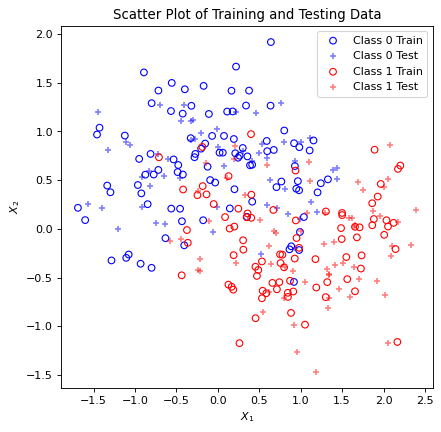

In [2]:
# 生成数据
X,y = make_moons(n_samples=300,noise=0.4,random_state=2022)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=0)
# 绘制数据
fig = plt.figure(figsize=(6,6),dpi=80)
colors = ["blue","red"] # 设定两种类别的颜色
for cls in [0,1]:
    plt.scatter(X_train[y_train==cls,0],X_train[y_train==cls,1],c='None',edgecolors=colors[cls],label="Class %d Train"%(cls))
    plt.scatter(X_test[y_test==cls,0],X_test[y_test==cls,1],c=colors[cls],marker='+',alpha=0.5,label="Class %d Test"%(cls))
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("Scatter Plot of Training and Testing Data")
plt.legend()

我们利用`sklearn`中的`KNeighborsClassifier`方法来实现**KNN分类器**，然后设定不同的 $k$ 值，绘制模型在测试集上的准确率随着 $k$ 的变化情况

In [3]:
acc_test = [] # 用一个列表存储准确率分数
k_list = list(range(1,50)) # k 取 1, 2, ..., 50，用列表存储
for k in k_list:
    # 构建模型, 使用欧式距离，即 L2 距离
    knn_model = KNeighborsClassifier(n_neighbors=k,p=2)
    # 训练模型，完成空间划分
    knn_model.fit(X_train,y_train)
    # 在测试机上预测
    y_pred = knn_model.predict(X_test)
    # 计算正确率，并添加到列表中保存
    acc_test.append(accuracy_score(y_test,y_pred))

Text(0.5, 1.0, 'The Relationship between Accuracy and $k$ on Test Data')

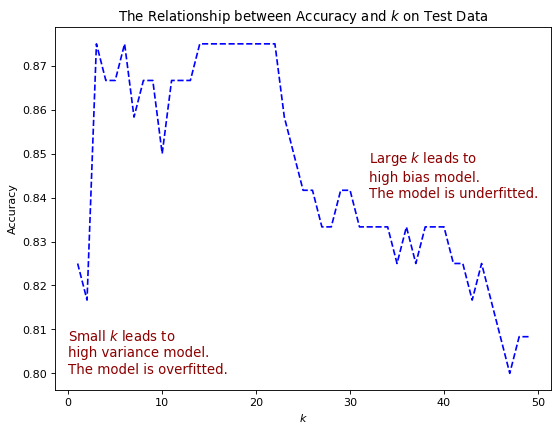

In [4]:
# 绘制准确率随 k 的变化情况
fig = plt.figure(figsize=(8,6),dpi=80)
plt.plot(k_list,acc_test,ls='--',c='blue')
plt.text(0,0.80,"Small $k$ leads to \nhigh variance model.\nThe model is overfitted.",fontdict={"color": "darkred", "fontsize": 12})
plt.text(32,0.84,"Large $k$ leads to \nhigh bias model.\nThe model is underfitted.",fontdict={"color": "darkred", "fontsize": 12})
plt.xlabel("$k$")
plt.ylabel("Accuracy")
plt.title("The Relationship between Accuracy and $k$ on Test Data")

正如前面所讨论的那样，$k$ 代表了**KNN模型的复杂度**：
* $k$ 越小，模型复杂度越高，**KNN容易过拟合**，从偏差-方差分解的角度，我们得到了一个**高方差**模型
* $k$ 越大，模型复杂度越低，**KNN容易欠拟合**，从偏差-方差分解的角度，我们得到了一个**高偏差**模型

一个合适的 $k$ 值能够帮助我们在测试集上取得不错的成绩，你还可以绘制出**训练集准确率与** $k$ **的关系曲线**进一步验证前面几节中我们讨论过的方差-偏差权衡问题，在不会绘制曲线前，你能猜想到曲线大致的趋势吗？

随着模型讨论的深入以及各种新方法的引入，我们会发现**方差-偏差权衡**或者说**过拟合和欠拟合的判别**是任何机器学习模型都绕不开的话题

### **1.5 kd树**

在这一节，我们介绍**如何快速找到** $k$ **个最近邻居的方法**，这一部分知识**不属于**机器学习知识的范畴，包含的知识主要是**算法和数据结构**，讨论的是关于**KNN的高效实现**问题

如果你只关注**KNN算法原理本身**，可以跳过这一部分内容，但如果你想更深入了解该算法的高效实现，以后也想和**算法**打交道，那么接下来的内容还是值得一看的

实现KNN算法，主要考虑的问题是如何对训练数据进行快速的 $k$ 近邻搜索，这在特征空间维度 $p$ 较大以及训练数据的样本量 $N$ 较大时显得尤为重要

假设计算一对样本之间的距离度量所需花费的时间是 $M(p)$，它和空间维度 $p$ 有关且 $M(p)$ 对 $p$ 单调递增$k$，近邻搜索的最简单的想法是**线性扫描**，即对于每个给定的测试实例 $x$，我们计算它和所有训练数据 $T$ 中每一个实例的距离，然后在其中找到最近的 $k$ 个，因此，**线性扫描方法**完成单个样本预测所需要的计算复杂度 $T$ 为：
$$
T = M(p)\cdot N
$$

可以看到，这在 $N$ 很大，$p$ 很大的时候，**计算非常耗时**，这种方法在实际操作中是不可行的

并且上述计算复杂度也只是一个粗糙的估计，真实的复杂度还会比上式要大，因为我们还没有考虑"从 $N$ 个距离度量中找到前 $k$ 小的距离"所需要的计算量，实现该目标可以借助[**优先队列**](https://baike.baidu.com/item/%E4%BC%98%E5%85%88%E9%98%9F%E5%88%97/9354754?fr=aladdin)等其他数据结构，这里不做展开

为了提高 $k$ 近邻搜索的效率，可以考虑**使用特殊的数据结构存储训练集**，以减少计算距离的次数，具体方法有很多，我们以**kd树**（**kd-tree**）为例进行介绍，kd树算法分为两个部分：**构造kd树**和**搜索kd树**

#### **1.5.1 构造kd树**

kd树是一种对 $p$ 维空间中的实例点进行存储以便对其进行快速检索的**树形**数据结构. **kd树是二叉树**，表示对 $p$ 维空间的一个**划分**. **构造kd树相当于不断地用垂直于坐标轴的超平面将** $p$ **维空间切分**，构成一系列的 $p$ 维**超矩形区域**，kd树的**每个结点对应于一个** $p$ **维超矩形区域**

构造kd树的方法如下：首先构造**根结点**，使**根结点对应于** $p$ **维空间中包含所有实例点的超矩形区域**，然后通过下面的**递归方法**，不断地对 $p$ 维空间进行切分，生成子结点. 
* 在超矩形区域（**结点**）上选择一个**坐标轴**和在此坐标轴上的一个**切分点**，确定一个**超平面**（$p-1$ 维），这个**超平面通过选定的切分点并垂直于选定的坐标轴**
* 将当前超矩形区域切分为**左右两个子区域**，对应得到**左右两个子结点**
* 这时，实例点会被划分到两个子区域，这个过程**直到子区域内没有实例时停止**（终止时的结点为叶结点）  

在上述的递归过程中，将实例保存在相应的结点上. 通常，**依次选择坐标轴对空间进行切分**，并选择**训练实例点**在**选定坐标轴**上的**中位数**作为**切分点**，这样做得到的kd树是**平衡的**，**平衡的kd树一定程度上保证了第二阶段搜索kd树的效率**，但**未必是最优的**，[**平衡二叉树AVL**](https://www.cnblogs.com/sench/p/7786718.html)是树形数据结构中很重要的一种，简单来说，它需要满足：
* 左子树和右子树都是平衡二叉树
* 左子树和右子树的深度（高度）之差的绝对值不超过1

更多的讨论和细节请参考**数据结构和算法**有关知识，这里不能做过多展开

我们将**构造kd树**的算法流程用标准的语言表达如下：

* **输入**：$p$ 维空间训练集 $T=\{x_1,x_2,\cdots,x_N\}$，其中，$x_i = \left(x_i^{(1)},\cdots,x_i^{(p)}\right)\in\mathbb{R}^p$
* **输出**：一颗kd树
* **算法流程**：
  * (1) 构造树的根结点，根结点对应于包含整个 $T$ 的 $p$ 维空间的超矩形区域
  * (2) 选择 $x^{(1)}$ （第一分量）为坐标轴，以 $T$ 中所有实例的 $x^{(1)}$ 坐标的中位数为切分点，将根结点对应的超矩形区域划分为两个子区域，切分由通过切分点并与坐标轴 $x^{(1)}$ 垂直的超平面实现
  * (3) 由根结点生成深度为 $1$ 的左右子结点，左子结点对应坐标 $x^{(1)}$ 小于切分点的子区域，右子结点对应坐标 $x^{(1)}$ 大于切分点的子区域，将落在切分超平面上的实例保存在根结点上
  * (4) **重复**：对深度为 $j$ 的结点，选择 $x^{(k)},\quad k=j(\mod k)+1$ 为切分的坐标轴，以该结点的区域中所有的实例的 $x^{(k)}$ 坐标的中位数为切分点，按照(1)~(3)步骤划分得到两个子区域，得到两个深度为 $j+1$ 的子结点
  * **停止**：直到两个子区域没有实例存在（即不再需要切分）时停止，从而形成了kd树的区域划分

我们用一个例子来说明kd树的构造流程，假设我们有二维空间的训练集 $T$：
$$
T = \{(2,3),(5,4),(9,6),(4,7),(8,1),(7,2)\}
$$

则kd树构造后得到的空间划分如下图所示：

<img src="./source/Chap4/kd树划分区域.png" style="width: 500px" align="left"/>

我们得到的kd树的结构如下图所示：

<img src="./source/Chap4/kd树.png" style="width: 500px" align="left"/>

最后，我们指明，对于样本量为 $N$ 的训练集 $T$，**构造kd树所需要的计算复杂度为** $\mathcal{O}(N\log N)$

#### **1.5.2 搜索kd树**

利用kd树对空间划分的结构，我们能够省去大部分数据点的搜索，从而减少 $k$ 近邻搜索的计算量，下面我们以**最近邻**为例叙述**搜索kd树**的算法过程，这非常容易扩展到 $k$ 近邻搜索，即 $k>1$ 的场合

给定一个测试样例 $x$，我们用下面的流程在kd树中搜索它的最近邻：
* 首先，找到包含目标点 $x$ 的叶结点
* 然后，从该结点出发，依次**递归**回归到每一层父结点，不断查找与目标点最近邻的结点
  * **包含目标点** $x$ 的**叶结点**对应**包含目标点的最小超矩形区域**，以此叶结点的实例点作为当前的最近点，$x$ **的最近邻一定在以目标点为中心并通过当前最近点的超球体的内部**
  * 然后返回当前结点的**父结点**，如果**父结点的另一个子节点的超矩形区域与超球体相交**，那么在相交的区域内寻找与 $x$ 更近的实例点，**如果这样的点存在，则将此点更新为当前的最近点**
  * 算法**转到更上一级的父结点**，重复上述过程
  * 如果**父结点的另一个子结点的超矩形区域与超球体不相交，或不存在比当前最近点更近的点**，则无需搜索

搜索被限定在空间的局部区域上进行，因此比较次数远小于线性扫描的 $N$ 次，效率大大提高

我们将**搜索kd树**的算法流程用标准的语言表达如下：

* **输入**：已经构造好的kd树，查询测试样例 $x$
* **输出**：$x$ 的最近邻
* **算法流程**：
  * (1) 在kd树中找出包含 $x$ 的叶结点，从根节点出发，递归向下访问kd树，根据每个结点划分的坐标轴及切分点，可以决定应该向左还是向右递归，若目标点 $x$ 当前维的坐标小于切分点，则移动到左子结点，否则移动到右子结点，直到子结点为叶结点停止
  * (2) 以该叶结点为“当前最近邻”
  * (3) **递归地**向上回退，在每个结点进行如下操作
    * (a) 如果该结点保存的实例点比当前最近邻更近，则以该实例点为新的“当前最近邻”
    * (b) 当前最近邻一定存在于该结点一个子结点对应的区域，检查该子结点的父结点的另一子结点对应的区域是否有更近的点. 具体地，**检查另一个子结点对应的区域是否与以** $x$ **为球心**，**以** $x$ **和"当前最近邻"的距离为半径的超球体相交**
      * 如果相交，可能在另一个子结点对应的区域内存在距离更近的点，移动到另一个子结点，接着，**递归执行最近邻搜索算法**
      * 如果不相交，向上回退
  * (4) 当**回归到根节点**时无法继续回退时，搜索结束，最后的“当前最近邻”即为 $x$ 的最近邻点

我们接着刚才的例子，训练数据集 $T$ 依然是：
$$
T = \{(2,3),(5,4),(9,6),(4,7),(8,1),(7,2)\}
$$

假设要搜索的点是 $x=(2,5)$，如下图所示

<img src="./source/Chap4/搜索kd树.png" style="width: 500px" align="left"/>

一开始，我们可以判断 $x$ 落入叶结点 $(4,7)$ 所划定的超矩形区域，$(4,7)$ 也作为初始的"当前最近邻"，但很容易发现，真实的最近邻并不是 $(4,7)$，二十包含在以 $x$ 为圆心，$x$ 到 $(4,7)$ 的距离为半径的超球体范围内的另一个点 $(2,3)$

下图用kd树展示了整个搜索算法的执行过程，我们对每一步做出解释：
* (1)：根节点处，因为 $x^{(1)}=4 < 7$，进入左子节点分支 $(5,4)$
* (2)：因为 $x^{(2)}= 5 > 4$，进入右子节点分支 $(4,7)$，此时 $(4,7)$ 已经是叶结点，初始的“当前最近邻”为 $(4,7)$
* (3)：向上回退到父结点 $(5,4)$，$(5,4)$ 与 $x$ 的距离大于当前最近邻，不更新最近邻，$(5,4)$ 的另一个子结点 $(2,3)$ 包含的区域与当前最近邻超球体相交，准备跳转到 $(2,3)$
* (4)：跳转到叶结点 $(2,3)$，从这里**递归执行最近邻搜索算法**，由于以 $(2,3)$ 为根的子树只有 $(2,3)$ 一个结点，它即为子进程的最近邻，比较发现，$(2,3)$ 距 $x$ 更近，替换“当前最近邻”为 $(2,3)$
* (5)：结点 $(5,4)$ 的搜索结束，继续向上回退到父结点 $(7,2)$
* (6)：$(7,2)$ 的另一个子结点 $(9,6)$ 包含的区域与当前最近邻超球体不相交，不需要跳转到 $(9,6)$
* (7)：$(7,2)$ 已经是根节点，无法继续回归，搜索结束，算法得到的最近邻为 $(2,3)$

<img src="./source/Chap4/搜索过程.png" style="width: 500px" align="left"/>

我们最后指出，如果实例点是随机分布的，**kd树搜索每个测试实例点最近邻的平均（期望）计算复杂度是** $\mathcal{O}(\log N)$，这里 $N$ 即为训练集 $T$ 的样本量. 设想一下，这在 $N$ 很大的情况下，相比线性扫描的性能是成百上千倍的提升

kd树更适用于训练数据量 $N$ 远大于空间维度 $p$ 的 $k$ 近邻搜索，即$N\gg p$，当 $N\approx p$ 时，该方法的效率会迅速下降，几乎接近线性扫描

----

## **2 K-Means：K均值方法**

**K-Means**是一种**无监督**的**聚类方法**，它基于样本集合划分聚类，**K-Means**将样本集合划分为正好 $k$ 个子集，构成 $k$ 个类，然后将 $N$ 个样本分配到 $k$ 个类中

**K-Means**聚类结果的特点是**每个样本到其所属的类的中心的距离最小，且每个样本仅属于一个类**，因此**K-Means是硬聚类**

我们依然按照机器学习三要素：**模型、策略、算法**的顺序介绍**K-Means**方法

### **2.1 K-Means模型**

给定 $N$ 个样本的集合 $X={x_1,x_2,c\dots,x_n}$，每个样本 $x_i\in\mathbb{R}^p$，K均值聚类的目标是将 $N$ 个样本分到 $k$ 个不同的类（或称为簇）中，这里假设 $k<N$

$k$ 个类 $G_1,G_2,\cdots,G_k$ 形成对样本集合 $X$ 的划分，其中：
$$
G_i\cap G_j=\boldsymbol{\emptyset},i\ne j,\quad \bigcup_{i=1}^{k}G_i = X
$$

我们用 $C$ 表示划分，一个划分对应着一个聚类的结果，划分 $C$ 是一个多对一的函数. 事实上，如果把每个样本用一个整数 $i\in\{1,2,\cdots,N\}$ 表示，每个类用一个整数 $l\in \{1,2,\cdots,k\}$ 表示，那么划分结果可以用函数 $l=C(i)$ 表示. 所有K均值聚类的模型是一个从样本到类的函数.

### **2.2 K-Means策略**

K均值聚类归结为样本 $X$ 的划分，或者从样本到类的函数的选择问题. $k$ 均值聚类的策略是通过损失函数的最小化选取最优的划分或函数 $C^*$

首先，采用**欧式距离平方**作为样本之间的距离 $d(x_i,x_j)$：
$$
d(x_i,x_j) = \sum_{m=1}^{p}(x_i^{(m)} - x_j^{(m)})^2 = \|x_i - x_j\|_2^2
$$

然后，定义样本与其所属类的中心之间的距离的总和为损失函数，即：
$$
W(C) = \sum_{l=1}^{k}\sum_{C(i)=l} \|x_i - \overline{x}_l\|_2^2
$$

其中，$\overline{x}_l = (\overline{x}_l^{(1)},\cdots,\overline{x}_l^{(p)})$ 是第 $l$ 个类的**均值**或**重心**，$n_l$ 表示第 $l$ 个类中样本的数量：
$$
n_l = \sum_{i=1}^{n} \mathbb{I}(C(i)=l)
$$

函数 $W(C)$ 也被称为**能量函数**，它表示**相同类中，样本相似的程度**

K均值聚类的策略是求解下面的**最优化问题**：
$$
\begin{array}{rcl}
C^* & = & \mathop{\arg\min}\limits_{C} W(C) \\
& = & \mathop{\arg\min}\limits_{C} \sum_{l=1}^{k}\sum_{C(i)=l} \|x_i - \overline{x}_l\|_2^2
\end{array}
$$

相似的样本被聚到同类时，**损失函数** $W(C)$ **的值最小**，这个目标函数的最优化能达到聚类的目的，但是，这是一个**组合优化**问题，将 $N$ 个样本分配到 $k$ 类，所有可能的方法树目是：
$$
S(N,k) = \frac{1}{k!}\sum_{l=0}^{k}(-1)^{k-l}\binom{k}{l}(k-l)^N
$$

$S(N,k)$ 是指数级的，也被称为**斯特林第二类数**，我们没有办法通过枚举搜索的方式求解，事实上，K均值聚类的最优解求解问题是**NP困难问题**，我们会使用**迭代求解**的方法进行

### **2.3 K-Means算法**

K均值聚类的算法是一个迭代的过程，每次迭代包括两个步骤. 首先选择 $k$ 个类的中心，**将样本诸葛指派到与其最近的中心的类中**，得到一个聚类结果，然后**更新每个类的样本的均值**（更新重心），作为类的新的中心，重负上述两个步骤，直到收敛

具体来说：
* 首先，对于给定的 $k$ 个中心 $(m_1,m_2,\cdots,m_k)$，求一个划分 $C$，使得目标函数极小化：
$$
\min_C \sum_{l=1}^{k}\sum_{C(i)=l} \|x_i - m_l\|_2^2
$$
即**在类别中心已经确定的情况下，将每个样本分配到一个类中**，使样本何其所属类的中心之间的距离综合最小. 很容易想到最优方案是，将每个样本指派到与其最接近的中心 $m_l$ 的类 $G_l$ 中
* 然后，对于给定的划分 $C$，再求哥哥类的中心 $(m_1,m_2,\cdots,m_k)$，使得目标函数极小化：
$$
\min_{m_1,\cdots,m_k} \sum_{l=1}^{k}\sum_{C(i)=l} \|x_i - m_l\|_2^2
$$
这一步是说，**在划分给定的情况下，是样本和其所属的类的中心之间的距离总和最小**，对上式每个 $m_l$ 求偏导可得，对于每个包含 $n_l$ 个样本的类 $G_l$，更新其中心均值 $m_l$ 为：
$$
m_l = \frac{1}{n_l}\sum_{C(i)=l} x_i,\quad l=1,\cdots,k
$$

重复以上的两个步骤，**直到划分** $C$ **不再改变**，或者说**聚类中心** $(m_1,\cdots,m_k)$ **不再改变**，得到聚类结果

我们用标准的语言描述K均值聚类的算法流程：
* **输入**：$N$ 个样本的集合 $X$
* **输出**：样本集合的聚类 $C^*$
* **算法流程**
  * (1) 初始化：零 $t=0$，随机选择 $k$ 个样本点作为初始聚类中心 $\boldsymbol{m}^{(0)}=(m_1^{(0)},\cdots,m_k^{(0)})$
  * (2) 对样本进行聚类，对固定的类中心 $\boldsymbol{m}^{(t)}$，计算每个样本到类中心的距离，将每个样本指派到与其最近的中心的类中，构成聚类结果 $C^{(t)}$
  * (3) 计算新的类中心，对聚类结果 $C^{(t)}$，计算当前各个类的样本的均值作为新的中心 $\boldsymbol{m}^{(t+1)}$，然后 $t=t+1$
  * (4) 检查迭代是否满足收敛条件，满足条件输出 $C^* = C^{(t)}$，否则 $t=t+1$，然后返回到第(2)步

**K均值聚类算法的计算复杂度为** $\mathcal{O}(Npk)$，$N$ 表示样本量，$p$ 是特征维度，$k$ 是类别个数

下面，我们定义一个函数来展示K均值聚类的更新过程

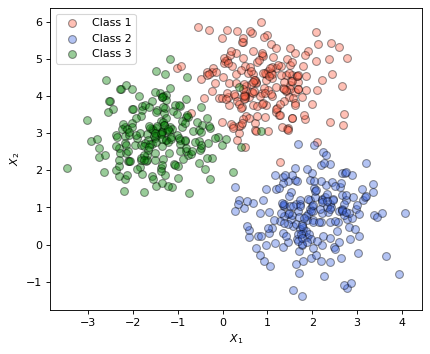

In [5]:
# 生成数据，真实的类别含有 3 类
X, labels = make_blobs(n_samples=600,n_features=2,centers=3,cluster_std=0.75,random_state=0)
colors = ["tomato","royalblue","green"]
# 绘制聚类情况
fig = plt.figure(figsize=(6,5),dpi=80)
for i in range(3):
    plt.scatter(X[labels==i,0],X[labels==i,1],c=colors[i],edgecolors="black",alpha=0.4,label="Class %d"%(i+1),s=50)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.legend()

In [6]:
# 展示K均值聚类的动态过程
def show_clustering(X : np.ndarray, k : int, colors : list):
    """
    show_clustering(X : np.ndarray, k : int)
        动态展示K均值聚类过程
    
    Parameters
    ----------
    X : np.ndarray
        样本集合，维度`(N,p)`
    k : int
        聚类的个数
    colors : list
        为每个类指定颜色
    """
    # 将样本分配到每个类
    def assign_cluster(X : np.ndarray, centers : np.ndarray):
        # 统计样本量
        N = X.shape[0]
        # 计算 X 到每个聚类中心的距离
        dist = np.zeros((N,k))
        for i in range(k):
            dist[:,i] = np.linalg.norm(X - centers[i],axis=1)
        # 找到每个样本最近的类
        labels = np.argmin(dist,axis=1)
        return labels
    
    # 绘制聚类分布
    def plot_cluster(X : np.ndarray, labels : np.ndarray, ax, fig):
        # 清理画布并重新画图
        ax.clear()
        for i in range(k):
            ax.scatter(X[labels==i,0],X[labels==i,1],c=colors[i],edgecolors="black",alpha=0.4,s=50)
        ax.set_xlabel("$X_1$")
        ax.set_ylabel("$X_2$")
        display.display(fig) # 展示画布
        display.clear_output(wait=True) # 清空画布
    
    # 统计维度
    p = X.shape[1]
    # 随机生成聚类中心
    centers = np.random.randn(k,p)*2
    # 初始化画板
    fig, ax = plt.subplots(1,1,figsize=(6,5),dpi=80)
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")
    
    # 初始化分配结果
    labels = assign_cluster(X=X,centers=centers)
    plot_cluster(X,labels,ax,fig) # 绘制聚类

    while True:
        # 设置每次仅迭代一步
        model = KMeans(n_clusters=k,max_iter=1,init=centers,random_state=0,n_init=1)
        model.fit(X)
        # 更新后的聚类中心
        centers_update = model.cluster_centers_
        # 达到停止条件
        if np.linalg.norm(centers_update - centers) < 1e-8:
            break
        # 更新聚类中心
        centers = centers_update
        # 更新聚类图
        time.sleep(1) # 减慢动画
        labels = assign_cluster(X=X,centers=centers)
        plot_cluster(X,labels,ax,fig) # 绘制聚类

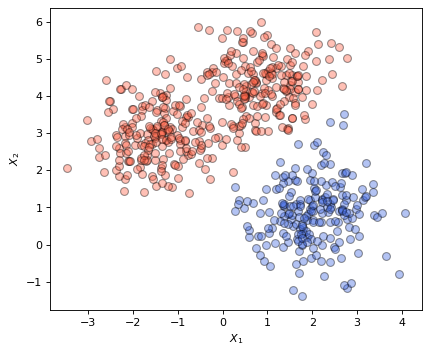

In [7]:
colors = ["tomato","royalblue","green","gold"]
show_clustering(X=X,k=2,colors=colors)

我们简单总结K均值聚类算法的几个特点：
* K均值聚类是基于划分的聚类方法，类别数 $k$ 需要事先给定，并以欧式距离表示样本之间的距离，以均值表示样本中心类别，以样本和其所属类别中心之间的距离总和作为最优化目标函数
* K均值聚类算法是迭代算法，该方法属于**启发式算法**，算法只保证**逐步最优**，无法保证收敛到**全局最优**
* 初始中心 $\boldsymbol{m}^{(0)}$ 的选择会直接影响聚类的结果，**初始中心可以使用随机初始化的方法确定**，也有其他方法辅助选择初始中心

### **2.4 如何选择 $k$ 值**

K均值聚类中的类别数 $k$ 值需要预先指定，而在实际应用中最优的 $k$ 值是不知道的，$k$ 值的选择可以通过尝试不同的 $k$ 值聚类，检验各个 $k$ 得到的聚类结果的质量来判断

聚类结果的质量可以使用**类的平均直径**来衡量，一般地，类别数变小，平均直径会增大，而当类别数变大超过某个值后，平均直径不会改变，或者说几乎不会改变，我们可以选择使平均直径下降到几乎不变前的 $k$ 值

另一种衡量聚类质量的方法，可以直接参考损失函数 $W(C)$，我们绘制 $W(C)$ 随 $k$ 的变化情况，它也会呈现与上述类平均直径相同的变化趋势，在一开始 $k$ 增大的时候，$W(C)$ 迅速下降，继续增大 $k$ 时，$W(C)$ 缓慢下降或几乎不变

以上两种方法都可以称为**手肘法**，我们从关于 $k$ 的聚类质量曲线中，找到**拐点**，并认为拐点处的 $k$ 值是最优的

下图展示了一般情形下，聚类质量 $Q$ 和类别数 $k$ 关系的曲线，图中的拐点即为我们所求

<img src="./source/Chap4/手肘法.png" style="width: 500px" align="left"/>

以前文的样本 `X` 为例，我们来计算不同聚类数量 `k` 下，损失的变化情况

In [8]:
def compute_clustering_loss(X : np.ndarray, k : int):
    # 创建模型，拟合模型
    model = KMeans(n_clusters=k)
    model.fit(X)
    # 计算每个样本所属的类别
    labels = model.predict(X)
    # 初始化损失
    loss = 0
    # 顺序迭代每一类样本
    for label in np.unique(labels):
        index = (labels == label) # 找到该类样本的索引
        X_sub = X[index] # 获取样本子集
        # 计算该类别样本的聚类中心
        center = np.mean(X_sub) 
        # 计算距离
        dist = np.linalg.norm(X_sub - center,ord=2)
        loss += (dist**2) # 添加到loss
    return loss

In [9]:
# 顺序迭代 k 值，取 k = 2,3,...,7
k_nums = np.arange(2,8)
losses = [] # 存储损失
for k in k_nums:
    loss = compute_clustering_loss(X,k=k)
    losses.append(loss)

Text(0, 0.5, 'Loss')

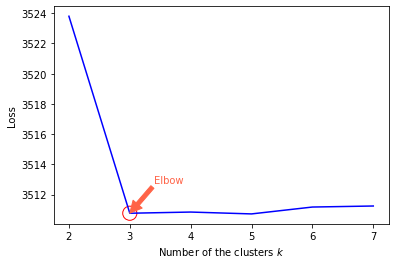

In [10]:
# 绘制手肘图
fig = plt.figure(figsize=(6,4))
plt.plot(k_nums,losses,c="blue")
plt.scatter(k_nums[1],losses[1],s=200,c="none",edgecolors="red")
plt.annotate("Elbow",(k_nums[1],losses[1]),
             (k_nums[1]+0.4,losses[1]+2),
             color="tomato",
             arrowprops=dict(facecolor='tomato',edgecolor="tomato",shrink=1))
plt.xlabel("Number of the clusters $k$")
plt.ylabel("Loss")

实际场景中，对于计算复杂度较小的场合，可以使用网格搜索的方式确定 $k$，如果计算复杂度较高，可以尝试使用**二分搜索**来找到最优的 $k$

另一种选择 $k$ 的方法是**借助有监督**的**下游任务**，来衡量模型划分结果的好坏，我们举一个例子具体说明

假设现在我们有大量的客户信息，并且根据专家经验，客户之间存在比较强的**异质性**，即客户的特征和偏好有明显不同，假设现在我们需要建立一个模型预测用户的购买行为
* 传统的方法，将所有用户放入到一个回归模型中，用一套系数对用户购买行为建模，但这没有考虑客户之间的**异质性**，模型可能存在很大偏差，预测效果差，假设预测正确率为 $P$
* 一种思路是，先对客户聚类，识别出用户的**异质性**将用户分层，假设分为 $k$ 类，然后在每个类中建立各自的回归模型，用 $k$ 套系数对用户的购买行为建模，此时不同模型适用不同类型的客户，模型偏差变小，预测性能提升，准确率 $P$ 上升
* 但事先不知道应该将用户聚为几个类别，此时类别个数 $k$ 的选择，就可以根据**下游任务**（即**用户购买行为预测**）的性能表现 $P$ 来抉择，$P$ 此时是与 $k$ 有关的函数，我们可以选择 $k^* = \mathop{\arg\max}\limits_{k} P(k)$

----

## **练习**

1. 考虑二维空间中的3个点 $x_1=(1,1)$，$x_2 = (5,1)$，$x_3=(4,4)$，用 $L_p$ 距离并取 $p=1,2,3,4$，计算不同 $L_p$ 距离下 $x_1$ 的最近邻点

2. 如果在使用KNN算法解决回归问题时，建模所考虑的损失函数是**绝对值损失**：
$$
L(y,\hat{y}) = |y - \hat{y}|
$$
请问，此时模型的最优决策规则是什么？

3. 如何将最近邻kd搜索树算法推广到 $k$ 近邻搜索？你的方案完成 $k$ 个最近邻搜索所需要的计算复杂度是多少？

4. 我们下面用KNN来完成一个回归任务

(1) 用`sklearn`提供的`make_regression()`函数，生成一组回归数据集，参数设置如下：
* 样本量`n_samples=400`
* 特征维度`n_features=6`
* 有效特征维度`n_informative=4`
* 噪声方差`noise=0.2`  

(2) 将数据集切分为训练集和测试集，测试集比例为 40%  
(3) 在训练集上训练KNN回归模型，可以直接利用`sklearn`提供的`KNeighborsRegressor`，回顾上一节提到的方法，如何**仅利用训练集数据**挑选出你觉得最合适的 $k$ 值  
(4) 用你的最优模型在测试集上预测，汇报模型在训练集和测试集上的均方误差，根据结果评价模型的性能表现（例如是否出现过拟合）

5. （**编程训练**）定义一个函数`MyKMeans()`实现K均值聚类算法，函数的接口说明和输出如下

In [11]:
import numpy as np
import random
def MyKMeans(X : np.ndarray, k : int) -> np.ndarray:
    """
    MyKMeans(X : np.ndarray, k : int) -> np.ndarray
        K均值聚类算法

    Parameters
    ----------
    X : np.ndarray
        样本集合，维度`(N,p)`
    k : int
        聚类的类别数量
    
    Return
    ----------
    labels : np.ndarray
        每个样本对应的类别编号
    """
    
    # 在下面完成你的代码
    N = len(X)
    #随机选择样本的下标
    X_sample = np.random.choice(N, k , False)
    #从而确定随机样本
    x = [X[i] for i in X_sample]
    #用来保存聚类方案
    cluster = np.zeros(N)
    #用来判断聚类方案有无变化
    temp = np.ones(N)
    #具体流程
    while temp != cluster:
        cluster = temp
        for i in range(N):
            dist = np.float64("inf")
            for j in range(k):
                temp_dist = np.linalg.norm(x[j] - X[i])
                if temp_dist < dist:
                    dist = temp_dist
                    temp[i] = j + 1

我们给出一些更纤细的说明，你可以按照下面的逻辑来完成**KMeans**算法

算法过程中需要两个子函数，以实现算法中对应的`类别分配`和`更新聚类中心`两个步骤，然后我们迭代进行这两个步骤

根据提示补充完成下面的代码

In [39]:
import numpy as np
def assign_cluster(X : np.ndarray, centers : np.ndarray):
    """
    给定聚类中心`centers`，将`X`中的每个样本分配到自己所属的类中

    Parameters
    ----------
    X : np.ndarray
        样本特征，维度`(N,p)`
    centers : np.ndarray
        聚类中心，维度`(k,p)`，其中`k`表示聚类个数

    Return
    ----------
    labels : np.ndarray
        每个样本所属的类别标签，维度`(N,)`
    """

    # 补充完成编写代码
    # 第一步，计算每个样本 x∈X 到每个聚类中心的距离
    # 这会得到一个维度为 `(N,k)` 的矩阵
    m, n = len(X), len(centers)
    dist = np.empty((m, n))
    for i in range(m):
        for j in range(n):
            dist[i][j] = np.linalg.norm(centers[j] - X[i])
    # 第二步，分配所属类别时，可以选取每一行的最小值的下标得到
    # np.argmin()可以实现这个功能，请查看对应的参数设置说明
    labels = np.argmin(dist, axis = 1)
    return labels

In [40]:
def update_centers(X : np.ndarray, labels : np.ndarray, centers : np.ndarray):
    """
    给定每个样本所属的类别标签，重新计算聚类中心`centers`

    Parameters
    ----------
    X : np.ndarray
        样本特征，维度`(N,p)`
    labels : np.ndarray
        每个样本所属的类别标签，维度`(N,)`
    centers_old : np.ndarray
        更新前的聚类中心，维度`(k,p)`

    Return
    ----------
    centers : np.ndarray
        聚类中心，维度`(k,p)`，其中`k`表示聚类个数
    """

    # 补充完成编写代码
    # 第一步，获取聚类数量
    k = len(centers)
    
    # 第二步，顺序选取每一类样本
    # 计算它们的中心，然后赋值给 centers
    for i in range(k):
        # 选取属于类别 i 的样本
        # X_subset 的维度为`(Ni,p)`
        X_subset = X[labels == i]
        
        # 计算样本子集的中心，然后赋值
        # 这个中心应该是一个`p`维向量
        if len(X_subset) > 0: # 确保有属于该类别的样本存在再赋值
            centers[i] = X_subset.mean(axis = 0)
    
    return centers

接下来，我们利用编写好的子函数`assign_cluster()`和`update_centers()`实现**KMeans**算法

为了便于理解，我们在函数中加入了可视化的部分，它们不影响**Kmeans**算法的执行，可以忽略它们

In [41]:
def MyKMeans(X : np.ndarray, k : int) -> np.ndarray:
    """
    MyKMeans(X : np.ndarray, k : int) -> np.ndarray
        K均值聚类算法

    Parameters
    ----------
    X : np.ndarray
        样本集合，维度`(N,p)`
    k : int
        聚类的类别数量
    
    Return
    ----------
    labels : np.ndarray
        每个样本对应的类别编号
    """
    # 绘制聚类分布
    def plot_cluster(X : np.ndarray, labels : np.ndarray, ax, fig, colors):
        # 清理画布并重新画图
        ax.clear()
        for i in range(k):
            ax.scatter(X[labels==i,0],X[labels==i,1],
                       facecolor=colors[i],edgecolors="black",alpha=0.3,s=30)
        ax.set_xlabel("$X_1$")
        ax.set_ylabel("$X_2$")
        display.display(fig) # 展示画布
        display.clear_output(wait=True) # 清空画布
    
    # 绘制聚类中心
    def plot_centers(centers : np.ndarray, ax, fig, colors, old_centers=None):
        for i in range(k):
            ax.scatter([centers[i][0]],[centers[i][1]],facecolor=colors[i],edgecolors="None",s=150,
                       marker="p",label="cluster %d"%(i+1))
        if old_centers is None:
            ax.legend()
        # 绘制聚类中心的更新方向
        else:
            for i in range(k):
                ax.arrow(old_centers[i][0],old_centers[i][1],
                         centers[i][0]-old_centers[i][0],centers[i][1]-old_centers[i][1],
                         color="black",head_width=0.15,head_length=0.2,
                         length_includes_head=True,linewidth=0.5)
        display.display(fig) # 展示画布
        display.clear_output(wait=True) # 清空画布
    
    # 获取样本量和特征维度
    N, p = X.shape[0], X.shape[1]
    
    # 初始化聚类中心
    # 你可以随机选取
    # 也可以从样本 X 中随机挑选 k 个点
    centers = np.random.randn(k,p) # 随机选取
    old_centers = np.zeros_like(centers)

    # 初始化画板
    fig, ax = plt.subplots(1,1,figsize=(8,8),dpi=80)
    colors = sns.palettes.color_palette("muted") # 设置颜料盘
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")
    
    # 开始迭代，直到聚类中心 centers 不再发生改变
    while np.linalg.norm(centers - old_centers) > 1e-8:
        # 拷贝上一步的聚类中心
        old_centers = centers.copy()
        
        # 交替进行两个步骤
        # 第一步：分配类别标签
        labels = assign_cluster(X,centers)
        
        # 绘制聚类分配结果
        time.sleep(1) # 减慢动画
        plot_cluster(X,labels,ax,fig,colors)
        plot_centers(centers,ax,fig,colors)
        
        # 第二步，更新聚类中心
        centers = update_centers(X,labels,centers)
        
        # 绘制聚类中心的更新过程
        time.sleep(1) # 减慢动画
        plot_centers(centers,ax,fig,colors,old_centers)
    
    return labels

用下面的数据进行实验吧

In [42]:
X, labels = make_blobs(n_samples=600,n_features=2,centers=3,cluster_std=0.75,random_state=0)

你可以设置不同的 $k$ 值来观察聚类的更新过程

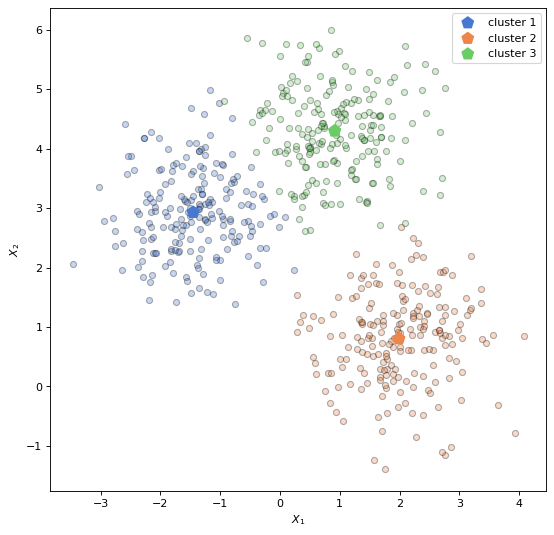

In [48]:
labels_pred = MyKMeans(X,k=3)

6. 谈一谈KNN算法相比之前介绍的线性回归、逻辑回归和朴素贝叶斯方法而言，有什么异同点？它是一种**线性方法**还是**非线性方法**？你觉得它最大的优势是什么？